<a href="https://colab.research.google.com/github/CassiaFa/Analyse_Donnees/blob/main/mask_detection_Fabio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Création de l'accès au dossier drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import os
os.chdir("/gdrive/MyDrive/Reconnaissance_masque")
cwd = os.getcwd()
print(cwd)

/gdrive/MyDrive/Reconnaissance_masque


# Importation des bibliothèques

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import tqdm
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input

# Quelques variables

In [4]:
img_shape = (224,224)
nb_classe = 2

# Préparation du jeu de données

## Récupération du chemin des données depuis le dossier drive

In [5]:
import pathlib
dataset_path = os.path.join(cwd, "DataSet")
data_dir = pathlib.Path(dataset_path)
data_dir.glob("*/*.*")
image_count = len(list(data_dir.glob("*/*.*")))
print(image_count)

1508


In [6]:
with_mask = list(data_dir.glob("with_mask/*"))
without_mask = list(data_dir.glob("without_mask/*"))

## Affichage d'une image

In [7]:
print(str(with_mask[1]))
img = cv2.imread(str(with_mask[1]))
img.shape

img = cv2.resize(img, img_shape)

/gdrive/MyDrive/Reconnaissance_masque/DataSet/with_mask/augmented_image_118.jpg


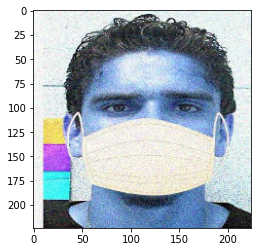

In [8]:
plt.imshow(img)
plt.show()

## Test du PreProcess de VGG16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


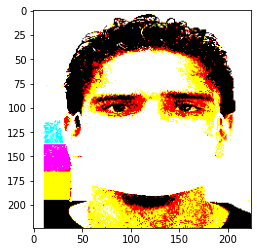

In [9]:
# b, g, r = cv2.split(img)
# img = cv2.merge([r,g,b])
x = preprocess_input(img)
plt.imshow(x)
plt.show()

## Importation des données

In [10]:
mask_image_dict = {
    'with_mask' : with_mask,
    'without_mask' : without_mask
}

In [11]:
mask_label_dict = {
    'with_mask' : 0,
    'without_mask' : 1
}

In [12]:
X, y = [], []

for mask_label, images in tqdm.tqdm(mask_image_dict.items()):
  for image in images :
    img = cv2.imread(str(image))
    ## ===== PreProcess ===== ##
    # b, g, r = cv2.split(img)
    # img = cv2.merge([r,g,b])
    # img = preprocess_input(img)
    ## ====================== ##
    resized_img = cv2.resize(img, img_shape)
    X.append(resized_img)
    y.append(mask_label_dict[mask_label])

X = np.array(X)/255.0
y = np.array(y)

100%|██████████| 2/2 [02:53<00:00, 86.57s/it]


## Séparation du DataSet en *Train*, *Validation*, *Test*

In [13]:
# Création du Train et Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Création du Validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.8, random_state=0)

## Catégorisation  des labels 

In [14]:
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes= 2)
y_validation_cat = tf.keras.utils.to_categorical(y_validation, num_classes= 2)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes= 2)

print(X_train.shape, X_validation.shape, X_test.shape)

(964, 224, 224, 3) (242, 224, 224, 3) (302, 224, 224, 3)


# Chargement du modèle VGG16

In [15]:
model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224)+(3,))

model_VGG16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [16]:
# Freezer les couches du VGG16
for layer in model_VGG16.layers: 
    layer.trainable = False

model = Sequential()
model.add(model_VGG16) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(4096,activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(nb_classe, activation='softmax'))

model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 2)                 8194      
                                                                 
Total params: 134,268,738
Trainable params: 119,554,050
Non-trainable params: 14,714,688
_________________________________________________________________


## Augmentation des données

In [17]:
#Configuration du data générateur

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

## Entrainement du modèle

In [18]:
EPOCHS = 50
checkpoint_filepath = cwd + '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# history = model.fit(X_train, y_train_cat, epochs=EPOCHS, callbacks=[model_checkpoint_callback], validation_data=(X_validation, y_validation_cat))
history = model.fit(datagen.flow(X_train, y_train_cat), epochs=EPOCHS, callbacks=[model_checkpoint_callback], validation_data=(X_validation, y_validation_cat))

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


31/31 [==============================] - 41s 918ms/step - loss: 4.5094 - accuracy: 0.8423 - val_loss: 0.7118 - val_accuracy: 0.8264
Epoch 2/50
31/31 [==============================] - 27s 875ms/step - loss: 0.0844 - accuracy: 0.9751 - val_loss: 0.2437 - val_accuracy: 0.9050
Epoch 3/50
31/31 [==============================] - 27s 880ms/step - loss: 0.0509 - accuracy: 0.9844 - val_loss: 0.0507 - val_accuracy: 0.9669
Epoch 4/50
31/31 [==============================] - 24s 756ms/step - loss: 0.0222 - accuracy: 0.9938 - val_loss: 0.4722 - val_accuracy: 0.8554
Epoch 5/50
31/31 [==============================] - 25s 793ms/step - loss: 0.0172 - accuracy: 0.9896 - val_loss: 0.0349 - val_accuracy: 0.9876
Epoch 6/50
31/31 [==============================] - 22s 716ms/step - loss: 0.0260 - accuracy: 0.9907 - val_loss: 0.1788 - val_accuracy: 0.9298
Epoch 7/50
31/31 [==============================] - 33s 1s/step - loss: 0.0362 - accuracy: 0.9886 - val_loss: 0.0951 - val_accuracy: 0.9711
Epoch 8/50
31

In [19]:
model.load_weights(checkpoint_filepath)

# Evaluation du model

## Courbe d'accuracy et de coût

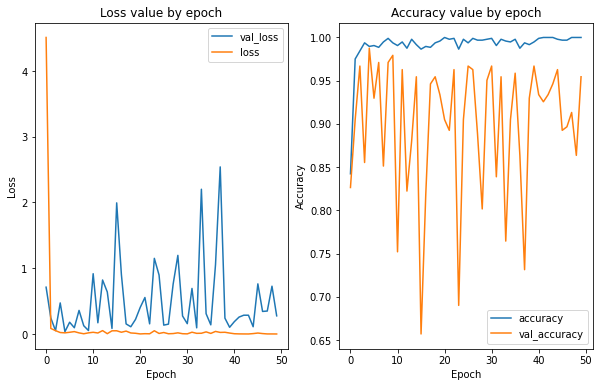

10/10 - 5s - loss: 0.0248 - accuracy: 0.9868 - 5s/epoch - 462ms/step


In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].plot(history.history['val_loss'], label = "val_loss")
ax[0].plot(history.history['loss'], label = "loss")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel("Loss")
ax[0].legend(loc = "upper right")
ax[0].set_title("Loss value by epoch")

ax[1].plot(history.history['accuracy'], label='accuracy')
ax[1].plot(history.history['val_accuracy'], label = 'val_accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
# ax[1].set_ylim([0.80, 1])
ax[1].legend(loc='lower right')
ax[1].set_title("Accuracy value by epoch")

plt.savefig(os.path.join(cwd,"accuracy_curve.png"))

plt.show()

test_loss, test_acc = model.evaluate(X_test,  y_test_cat, verbose=2)

In [21]:
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=-1)

In [22]:
# list(mask_label_dict.values()) 

In [23]:
# list(mask_label_dict.keys())[list(mask_label_dict.values()).index(y_pred)]

In [24]:
confusion_matrix = tf.math.confusion_matrix(
    y_test,
    y_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=mask_label_dict.keys()
)

confusion_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[157,   0],
       [  4, 141]], dtype=int32)>

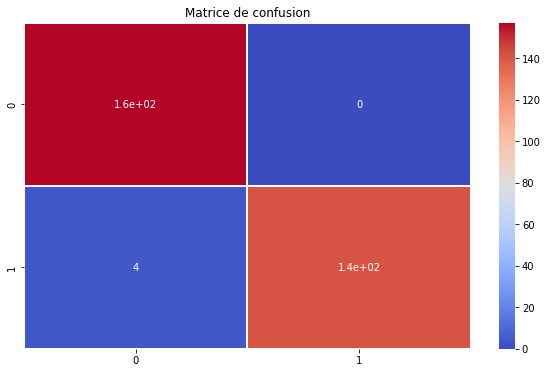

In [25]:
import seaborn as sn

plt.figure(figsize=(10,6))
sn.heatmap(confusion_matrix, annot=True,cmap='coolwarm', linecolor='white', linewidths=1)
plt.title("Matrice de confusion")

plt.savefig(os.path.join(cwd,"confusion_matrix.png"))

plt.show()

In [26]:
model.save(os.path.join(cwd, "model_mask.h5"), save_format="h5")

# Application du modèle avec la webcam

In [27]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


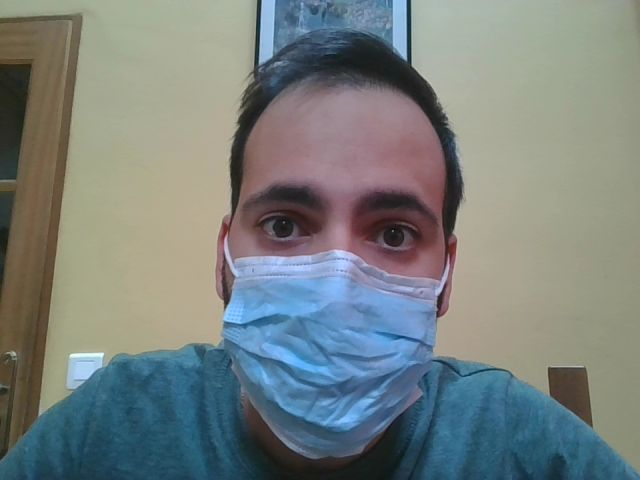

In [28]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [29]:
img = cv2.imread("photo.jpg")
img = cv2.resize(img, img_shape)
img = np.array(img)/255.0
img = np.expand_dims(img, axis=0)

test_prob = model.predict(img)
test_pred = test_prob.argmax(axis=-1)

In [30]:
list(mask_label_dict.keys())[list(mask_label_dict.values()).index(test_pred)]

'with_mask'